# Final Project | Prediction possibilities in a pandemic 
by Kevin Spurk

Text

# Table of content

1. 
2.
3.
...

# 1 | Setup

### 1.1 Libary imports

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import random
import datetime
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.set_option('max_row', None)

### 1.2 Data imports

### 1.2.1 google mobility data

- movement of people in different areas scales to 100 
- the baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020.

In [114]:
# csv import
data_mob_global = pd.read_csv('data/mobility_google/Global_Mobility_Report.csv')

data_mob_global.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [115]:
data_mob_global.shape

(7697738, 15)

In [116]:
data_mob_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7697738 entries, 0 to 7697737
Data columns (total 15 columns):
 #   Column                                              Dtype  
---  ------                                              -----  
 0   country_region_code                                 object 
 1   country_region                                      object 
 2   sub_region_1                                        object 
 3   sub_region_2                                        object 
 4   metro_area                                          object 
 5   iso_3166_2_code                                     object 
 6   census_fips_code                                    float64
 7   place_id                                            object 
 8   date                                                object 
 9   retail_and_recreation_percent_change_from_baseline  float64
 10  grocery_and_pharmacy_percent_change_from_baseline   float64
 11  parks_percent_change_from_baseline   

**results**

data contains:

features to keep:

### 1.2.2 facebook mobility data

In [117]:
# csv import
data_mob_fb = pd.read_csv('data/mobility_fb/movement-range-2021-11-07.txt', sep='\t')

In [118]:
data_mob_fb.head()

,ds,country,polygon_source,polygon_id,polygon_name,all_day_bing_tiles_visited_relative_change,all_day_ratio_single_tile_users,baseline_name,baseline_type
0,2021-01-01,AGO,GADM,AGO.10.10_1,Lubango,-0.35291,0.25398,full_february,DAY_OF_WEEK
1,2021-01-02,AGO,GADM,AGO.10.10_1,Lubango,-0.06131,0.17330,full_february,DAY_OF_WEEK
2,2021-01-03,AGO,GADM,AGO.10.10_1,Lubango,-0.00392,0.21932,full_february,DAY_OF_WEEK
3,2021-01-04,AGO,GADM,AGO.10.10_1,Lubango,0.15114,0.11662,full_february,DAY_OF_WEEK
4,2021-01-05,AGO,GADM,AGO.10.10_1,Lubango,0.12696,0.10832,full_february,DAY_OF_WEEK


In [119]:
data_mob_fb.shape

(4568692, 9)

In [120]:
data_mob_fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568692 entries, 0 to 4568691
Data columns (total 9 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   ds                                          object 
 1   country                                     object 
 2   polygon_source                              object 
 3   polygon_id                                  object 
 4   polygon_name                                object 
 5   all_day_bing_tiles_visited_relative_change  float64
 6   all_day_ratio_single_tile_users             float64
 7   baseline_name                               object 
 8   baseline_type                               object 
dtypes: float64(2), object(7)
memory usage: 313.7+ MB


### 1.2.3 google trends data

In [121]:
# connect to google and deepL APIs 
from pytrends.request import TrendReq
from pytrends import dailydata
from translate import Translator 

# get authentification for deepL API
with open('auth/deepl_auth_key.txt') as f:
    deepl_auth_key = f.read()

# google trends API access request
pytrends = TrendReq(hl='en-US', tz=0)

In [122]:
from pyf.apis import deepl_translate_list
from pyf.imex import df_to_csv_format

# keyword list 
keywords_list = ['covid', 'corona', 'SARS-CoV-2', 'virus', 'symptoms', 'fever', 'cough', 'tiredness', 'loss of smell', 'throat', 'shortness of breath', 'breathing issues', 'headache', 'diarrhea', 'chest pain', 'PCR', 'test', 'sick', 'infection']

# dict of countries and there languages to search in
countries_lang = {'GB': 'en', 'DE': 'de', 'FR': 'fr', 'NL': 'nl',
                  'ES': 'es', 'PT': 'pt', 'PL': 'pl', 'IT': 'it',
                  'AT': 'de', 'DK': 'da', 'SE': 'sv', 'GR': 'el',
                  'CZ': 'cs'}

# translating keyword list into target languages
# c19_kw_dict, c19_kw_df = deepl_translate_list(auth=deepl_auth_key, keywords=keywords_list, lang_out=countries_lang)

# export translations to csv
# df_to_csv_format(c19_kw_df, 'keywords_translations', '2')

c19_kw_df = pd.read_csv('data/multilanguage/keywords_translations_2.csv')


In [123]:
c19_kw_df

,GB,DE,FR,NL,ES,PT,PL,IT,AT,DK,SE,GR,CZ
0,covid,covid,covide,covid,covid,covid,covid,covid,covid,covid,covid,covid,covid
1,corona,corona,corona,corona,corona,corona,korona,corona,corona,corona,corona,corona,corona
2,SARS-CoV-2,SARS-CoV-2,SRAS-CoV-2,SARS-CoV-2,SARS-CoV-2,SRA-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
3,virus,Virus,virus,virus,virus,vírus,wirus,virus,Virus,virus,virus,ιός,virus
4,symptoms,Symptome,symptômes,symptomen,síntomas,sintomas,objawy,sintomi,Symptome,symptomer,symtom,συμπτώματα,příznaky
5,fever,Fieber,fièvre,koorts,fiebre,febre,gorączka,febbre,Fieber,feber,feber,πυρετός,horečka
6,cough,Husten,toux,hoest,toser,tosse,kaszel,tosse,Husten,hoste,hosta,βήχας,kašel
7,tiredness,Müdigkeit,fatigue,vermoeidheid,cansancio,cansaço,zmęczenie,stanchezza,Müdigkeit,træthed,trötthet,κούραση,únava
8,loss of smell,Geruchsverlust,la perte de l'odorat,verlies van reukzin,pérdida del olfato,perda do olfacto,utrata węchu,perdita dell'olfatto,Geruchsverlust,tab af lugt,förlust av lukt,απώλεια οσμής,ztráta čichu
9,throat,Kehle,gorge,keel,garganta,garganta,gardło,gola,Kehle,hals,hals,λαιμός,krk


In [124]:
import time
from datetime import date, timedelta
from pyf.apis import g_trends_ml

In [125]:
'''
c19_kw_p2 = c19_kw_dict

del c19_kw_p2['GB']
del c19_kw_p2['DE']
del c19_kw_p2['FR']
del c19_kw_p2['ES']
del c19_kw_p2['NL']
del c19_kw_p2['PL']
del c19_kw_p2['PT']
del c19_kw_p2['IT']

# get google trends data for keywords in all languages
c19_g_trends = g_trends_ml(kw_dict=c19_kw_p2, dt_start='2020-03', dt_end='2021-10', sleep_time=600)
'''

"\nc19_kw_p2 = c19_kw_dict\n\ndel c19_kw_p2['GB']\ndel c19_kw_p2['DE']\ndel c19_kw_p2['FR']\ndel c19_kw_p2['ES']\ndel c19_kw_p2['NL']\ndel c19_kw_p2['PL']\ndel c19_kw_p2['PT']\ndel c19_kw_p2['IT']\n\n# get google trends data for keywords in all languages\nc19_g_trends = g_trends_ml(kw_dict=c19_kw_p2, dt_start='2020-03', dt_end='2021-10', sleep_time=600)\n"

In [126]:
import glob
from pyf.imex import import_concat_csv

# import google trends data from csv files
data_g_trends = import_concat_csv('data/keywords_google/', 'g_trend_2020-03_2021-10_GB')
     

In [127]:
data_g_trends.head()

,date,covid,corona,SARS-CoV-2,virus,symptoms,fever,cough,tiredness,loss of smell,throat,shortness of breath,breathing issues,headache,chest pain,corona test,covid test,test,sick,infection,location
0,2020-03-01,0.25,6.27,1.52,10.75,23.01,13.94,5.20,33.58,0.00,13.94,11.22,0.0,21.28,31.90,0.60,0.0,22.40,13.50,59.64,GB
1,2020-03-02,0.35,8.58,2.80,14.62,28.91,14.76,5.46,31.39,0.00,14.35,13.86,0.0,20.72,20.88,2.04,0.0,28.16,13.50,65.52,GB
2,2020-03-03,0.35,8.91,0.00,14.62,29.50,11.89,5.98,45.99,0.04,14.35,9.57,0.0,24.08,28.42,2.04,0.0,29.44,14.40,59.64,GB
3,2020-03-04,0.50,10.89,1.44,18.06,30.09,10.25,5.20,45.99,0.00,14.76,7.92,0.0,25.20,22.62,2.64,0.0,27.52,22.95,67.20,GB
4,2020-03-05,0.50,12.21,0.00,18.92,28.91,13.53,5.20,35.77,0.00,14.76,11.55,0.0,22.40,16.82,2.04,0.0,27.84,14.85,65.52,GB


In [128]:
len(data_g_trends)

4880

In [129]:
'''
def trends_complete_timeframe(df, dt_start, dt_end, kw_listed):
    
    # convert input to datetime
    dt_s = datetime.datetime.strptime(dt_start, '%Y-%m-%d').date()
    dt_e = datetime.datetime.strptime(dt_end, '%Y-%m-%d').date()
    # lists for missing days
    dates_missing = []
    trend_missing = []
    
    # loop to find missing dates in df
    while dt_s <= dt_e:
        date_check = False
        for d in df['date']:
            if d == dt_s:
                date_check = True
        # append missing date to lists
        if date_check == False:
            dates_missing.append(dt_s)
            trend_missing.append(np.NaN)
        dt_s += timedelta(days=1)
    
    # df for missing dates
    df_dates_missing = pd.DataFrame({'date': dates_missing, kw_listed[0]: trend_missing})
    df_completed = pd.concat([df, df_dates_missing], axis=0)
    df_completed['date'] = pd.to_datetime(df_completed['date'], errors='coerce')
    df_completed = df_completed.sort_values(by=['date'], ignore_index=True)
    
    return df_completed   


def trends_df_transform(df):
    # drop unwanted col
    for col in df.columns:
        if col == 'isPartial':
            df = df.drop(['isPartial'], axis=1)
            
    # get date as col
    df.reset_index(inplace=True)
    df['date'] = df['date'].dt.date
    
    # group rows by date
    df = df.groupby(['date']).mean()
    df.reset_index(inplace=True)
    df['date'] = df['date'].dt.date
    
    return df

def df_to_csv_format(df, name_cst, name_var, index=False):
    file_name = name_cst + '_' + name_var
    df.to_csv(f'{file_name}.csv', sep=',', index=index)
    return df


def trends_multilang(kw_dict, dt_start, dt_end, main_lang='GB', cat=0, sleep=60):
    # df for all results
    trends_all = pd.DataFrame({})
    
    # build timeframe str for api
    timeframe = dt_start + ' ' + dt_end
    
    # loop through lang
    for geo in kw_dict.keys():
        # df for results of one loc
        search_trend = pd.DataFrame({})
        # reformat kw list for sub func
        kw_group = list(zip(*[iter(kw_dict[geo])]*1))
        kw_listlist = [list(kw) for kw in kw_group]
        
        # loop through keywords
        for k in kw_listlist:
            # build payload
            print(k)
            try:
                pytrends.build_payload(kw_list=k, cat=cat, timeframe=timeframe, geo=geo)
                # get df with search trend for kw
                k_trend = pytrends.get_historical_interest(k, year_start=int(dt_start.split('-')[0]), month_start=int(dt_start.split('-')[1]), day_start=int(dt_start.split('-')[2]), hour_start=0, year_end=int(dt_end.split('-')[0]), month_end=int(dt_end.split('-')[1]), day_end=int(dt_end.split('-')[2]), hour_end=23, sleep=sleep)
                time.sleep(10)
                print(k_trend.head())
            except requests.exceptions.Timeout:
                print('Timeout occured.')
            
            # transform df
            k_trend = trends_df_transform(k_trend)
            
            # add missing dates
            k_trend_completed = trends_complete_timeframe(df=k_trend, dt_start=dt_start, dt_end=dt_end, kw_listed=k)
            
            # add df with search trend for kw to df for results of one loc
            search_trend['date'] = k_trend_completed['date']
            search_trend[k[0]] = k_trend_completed[k[0]]
        
        # add loc to df 
        search_trend['loc'] = geo
        # export df to csv
        search_details = dt_start + '_' + dt_end + geo
        df_to_csv_format(df=search_trend, name_cst='g_trend', name_var=search_details, index=False)
        
        # concat df with df holding all results
        if len(trends_all) > 0:
            search_details.columns = trends_all.columns
        trends_all = pd.concat([trends_all, search_details], axis=0)
        trends_all.reset_index(inplace=True)
        trends_all = trends_all.sort_values(by=['date'], ignore_index=True)
    
    return trends_all
'''

"\ndef trends_complete_timeframe(df, dt_start, dt_end, kw_listed):\n    \n    # convert input to datetime\n    dt_s = datetime.datetime.strptime(dt_start, '%Y-%m-%d').date()\n    dt_e = datetime.datetime.strptime(dt_end, '%Y-%m-%d').date()\n    # lists for missing days\n    dates_missing = []\n    trend_missing = []\n    \n    # loop to find missing dates in df\n    while dt_s <= dt_e:\n        date_check = False\n        for d in df['date']:\n            if d == dt_s:\n                date_check = True\n        # append missing date to lists\n        if date_check == False:\n            dates_missing.append(dt_s)\n            trend_missing.append(np.NaN)\n        dt_s += timedelta(days=1)\n    \n    # df for missing dates\n    df_dates_missing = pd.DataFrame({'date': dates_missing, kw_listed[0]: trend_missing})\n    df_completed = pd.concat([df, df_dates_missing], axis=0)\n    df_completed['date'] = pd.to_datetime(df_completed['date'], errors='coerce')\n    df_completed = df_completed

In [130]:
'''
date_t1 = datetime.datetime.strptime('2020-07-06', '%Y-%m-%d').date()
exists = date_t1 in data4['date']
exists
'''

"\ndate_t1 = datetime.datetime.strptime('2020-07-06', '%Y-%m-%d').date()\nexists = date_t1 in data4['date']\nexists\n"

In [131]:
'''
while test_date_start <= test_date_end:
    if test_date_start not in data4['date']:
        print(test_date_start.strftime('%Y-%m-%d'))
        test_date_start += timedelta(days=1)
'''

'''
for i in data4['date']:
    if i == test_date:
        date_present = True
    else:
        pass
        
print(date_present)
'''

"\nfor i in data4['date']:\n    if i == test_date:\n        date_present = True\n    else:\n        pass\n        \nprint(date_present)\n"

### 1.2.4 twitter trends data

In [132]:
import tweepy as tw 
from pyf.apis import tweepy_auth

# get authentification for twitter API
tw_api, tw_client = tweepy_auth('auth/tw_auth.txt')

Authentication OK


In [133]:
tweets = tw_client.get_recent_tweets_count(query='winter', granularity='day')
tweets

Response(data=[{'end': '2021-11-24T00:00:00.000Z', 'start': '2021-11-23T15:28:04.000Z', 'tweet_count': 108872}, {'end': '2021-11-25T00:00:00.000Z', 'start': '2021-11-24T00:00:00.000Z', 'tweet_count': 283738}, {'end': '2021-11-26T00:00:00.000Z', 'start': '2021-11-25T00:00:00.000Z', 'tweet_count': 274468}, {'end': '2021-11-27T00:00:00.000Z', 'start': '2021-11-26T00:00:00.000Z', 'tweet_count': 244829}, {'end': '2021-11-28T00:00:00.000Z', 'start': '2021-11-27T00:00:00.000Z', 'tweet_count': 296526}, {'end': '2021-11-29T00:00:00.000Z', 'start': '2021-11-28T00:00:00.000Z', 'tweet_count': 348549}, {'end': '2021-11-30T00:00:00.000Z', 'start': '2021-11-29T00:00:00.000Z', 'tweet_count': 393990}, {'end': '2021-11-30T15:28:04.000Z', 'start': '2021-11-30T00:00:00.000Z', 'tweet_count': 288736}], includes={}, errors=[], meta={'total_tweet_count': 2239708})

In [134]:
# import requests
# import json

### 1.2.5 Covid-19 data

In [135]:
# csv import
#data_c19_hospitalization = pd.read_csv('data/covid19/Covid19-hospital_and_ICU_admission_rates.csv')
#data_c19_cases = pd.read_csv('data/covid19/time_series_covid19_confirmed_global.csv')
#data_c19_deaths = pd.read_csv('data/covid19/time_series_covid19_deaths_global.csv')
#cases_daily_historical = pd.read_csv('data/covid19/cases_daily_historical.csv')
owid_covid_data = pd.read_csv('data/covid19/owid-covid-data.csv')

In [136]:
owid_covid_data[owid_covid_data['location'] == 'Germany'].head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
44670,DEU,Europe,Germany,2020-01-27,1.0,1.0,NaN,NaN,NaN,NaN,0.012,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
44671,DEU,Europe,Germany,2020-01-28,4.0,3.0,NaN,NaN,NaN,NaN,0.048,0.036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
44672,DEU,Europe,Germany,2020-01-29,4.0,0.0,NaN,NaN,NaN,NaN,0.048,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
44673,DEU,Europe,Germany,2020-01-30,4.0,0.0,NaN,NaN,NaN,NaN,0.048,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
44674,DEU,Europe,Germany,2020-01-31,5.0,1.0,NaN,NaN,NaN,NaN,0.060,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN


In [137]:
owid_covid_data.shape

(132430, 65)

In [138]:
owid_covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132430 entries, 0 to 132429
Data columns (total 65 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   iso_code                                 132430 non-null  object 
 1   continent                                123969 non-null  object 
 2   location                                 132430 non-null  object 
 3   date                                     132430 non-null  object 
 4   total_cases                              125203 non-null  float64
 5   new_cases                                125201 non-null  float64
 6   new_cases_smoothed                       124158 non-null  float64
 7   total_deaths                             114094 non-null  float64
 8   new_deaths                               114290 non-null  float64
 9   new_deaths_smoothed                      124158 non-null  float64
 10  total_cases_per_million         

# 2 | Data wrangling

### 2.1 google mobility data 

### 2.1.1 Feature elimination / subset selection

In [139]:
# dict of countries, country codes and there languages
tgt_countries = {'GB': ['en', 'united kingdom', 'GBR'], 'DE': ['de', 'germany', 'DEU'], 'FR': ['fr', 'france', 'FRA'], 'NL': ['nl', 'netherlands', 'NLD'],
                 'ES': ['es', 'spain', 'ESP'], 'PT': ['pt', 'portugal', 'PRT'], 'PL': ['pl', 'poland', 'POL'], 'IT': ['it', 'italy', 'ITA'],
                 'AT': ['de', 'austria', 'AUT'], 'DK': ['da', 'denmark', 'DNK'], 'SE': ['sv', 'sweden', 'SWE'], 'GR': ['el', 'greece', 'GRC'],
                 'CZ': ['cs', 'czechia', 'CZE']}


In [140]:
# getting subset of row with data of the target countries
countries_iso2 = [country_code for country_code in tgt_countries.keys()]
data_mobility = data_mob_global[data_mob_global['country_region_code'].isin(countries_iso2)]

# separating national data from regional data
data_mobility = data_mobility[data_mobility['sub_region_1'].isna()]

# dropping unneccessary columns
data_mobility = data_mobility.drop(data_mobility.iloc[:, 1:8], axis=1)


### 2.1.2. data cleaning

In [141]:
# convert 'date' column to datetime
data_mobility['date'] = pd.to_datetime(data_mobility['date'], errors='coerce')
data_mobility['date'] = data_mobility['date'].dt.date

data_mobility['date'].isna().sum()

0

In [142]:
# clean column names 
data_mobility.columns = data_mobility.columns.str.replace('_percent_change_from_baseline', '')

# rename country_region_code column
g_mob_columns = list(data_mobility.columns.values)
g_mob_new_columns = {col:col for col in g_mob_columns}
g_mob_new_columns['country_region_code'] = 'location'

data_mobility = data_mobility.rename(columns=g_mob_new_columns)

# rename locations into iso3 format
for key, val in tgt_countries.items():
    for i in range(len(data_mobility)):
        if key == data_mobility['location'].iloc[i]:
            data_mobility['location'].iloc[i] = val[2]
            

In [143]:
from pyf.preprocessing import timeframe_check_by_group, df_timeframe_limit, timeseries_interpolation_clustered, timeseries_clustered_sma, df_date_to_season
from pyf.preprocessing import value_overview


# check if range of dates is complete for all countries
mobility_timeframe = timeframe_check_by_group(df=data_mobility, groupby='location', timeframe='date')

timeframe: 2020-02-15 - 2021-11-17 
 no. of dates: 642 
 timeframe complete!


In [144]:
mobility_timeframe

,location,min_date,max_date,no_of_dates,expected_no_of_dates
0,AUT,2020-02-15,2021-11-17,642,642
1,CZE,2020-02-15,2021-11-17,642,642
2,DEU,2020-02-15,2021-11-17,642,642
3,DNK,2020-02-15,2021-11-17,642,642
4,ESP,2020-02-15,2021-11-17,642,642
5,FRA,2020-02-15,2021-11-17,642,642
6,GBR,2020-02-15,2021-11-17,642,642
7,GRC,2020-02-15,2021-11-17,642,642
8,ITA,2020-02-15,2021-11-17,642,642
9,NLD,2020-02-15,2021-11-17,642,642


In [145]:
# picking only df entries between Mar 2020 and Oct 2021
data_mobility = df_timeframe_limit(data_mobility, 'date', '2020-03-01', '2021-10-31')


In [146]:
mobility_timeframe = timeframe_check_by_group(df=data_mobility, groupby='location', timeframe='date')


timeframe: 2020-03-01 - 2021-10-31 
 no. of dates: 610 
 timeframe complete!


### 2.1.3. null values

In [147]:
g_mob_ov, g_mob_columns = value_overview(df=data_mobility, neg_allowed=True)

In [148]:
g_mob_ov

,type,unique values,NaN,NaN %,empty,empty %,zeros,zeros %,negative,negative %
location,object,13,0,0.00,0,0.0,0,0.00,0,0.00
date,object,610,0,0.00,0,0.0,0,0.00,0,0.00
retail_and_recreation,float64,142,0,0.00,0,0.0,156,1.97,6199,78.17
grocery_and_pharmacy,float64,203,1,0.01,0,0.0,273,3.44,3638,45.88
parks,float64,449,0,0.00,0,0.0,48,0.61,2028,25.57
transit_stations,float64,139,0,0.00,0,0.0,73,0.92,7306,92.13
workplaces,float64,116,0,0.00,0,0.0,89,1.12,7161,90.30
residential,float64,54,0,0.00,0,0.0,402,5.07,913,11.51


In [149]:
# interpolating null values
data_mobility = timeseries_interpolation_clustered(df=data_mobility, timeframe='date', cluster_by='location', method='polynomial', order=2)


In [150]:
data_mobility.isna().sum()

location                 0
date                     0
retail_and_recreation    0
grocery_and_pharmacy     0
parks                    0
transit_stations         0
workplaces               0
residential              0
dtype: int64

### 2.1.4 feature additions

In [151]:
# add season column
data_mobility = df_date_to_season(data_mobility, 'date')

# add columns with simple moving averages (5 days) of features
data_mobility_sma = timeseries_clustered_sma(df=data_mobility, cluster_by='location', timeframe='date', nod=5)

# interpolation of NaNs in first 4 days in sma columns
data_mobility_sma = timeseries_interpolation_clustered(df=data_mobility_sma, timeframe='date', cluster_by='location', method='backfill', limit_direction='backward')


In [152]:
data_mobility_sma.isna().sum()

location                        0
date                            0
retail_and_recreation           0
grocery_and_pharmacy            0
parks                           0
transit_stations                0
workplaces                      0
residential                     0
season                          0
retail_and_recreation_sma_5d    0
grocery_and_pharmacy_sma_5d     0
parks_sma_5d                    0
transit_stations_sma_5d         0
workplaces_sma_5d               0
residential_sma_5d              0
dtype: int64

### 2.2 facebook mobility data

### 2.2.1 feature elimination

In [153]:
countries_iso3 = [cn[2] for cn in tgt_countries.values()]
data_mob_fb = data_mob_fb[data_mob_fb['country'].isin(countries_iso3)]


In [154]:
data_mob_fb[data_mob_fb['country'] == 'DEU']['ds'].nunique()

311

### 2.3 google trends data

### 2.3.1 Feature elimination / subset selection

no feature eliminaltion


### 2.3.2. data cleaning

In [155]:
# convert 'date' column to datetime
data_g_trends['date'] = pd.to_datetime(data_g_trends['date'], errors='coerce')
data_g_trends['date'] = data_g_trends['date'].dt.date

data_g_trends['date'].isna().sum()

0

In [156]:
from pyf.preprocessing import clean_headers

# clean column names 
data_g_trends = clean_headers(data_g_trends)

# rename locations into iso3 format
for key, val in tgt_countries.items():
    for i in range(len(data_g_trends)):
        if key == data_g_trends['location'].iloc[i]:
            data_g_trends['location'].iloc[i] = val[2]
            

In [157]:
# check if range of dates is complete for all countries
g_trends_timeframe = timeframe_check_by_group(df=data_g_trends, groupby='location', timeframe='date')

timeframe: 2020-03-01 - 2021-10-31 
 no. of dates: 610 
 timeframe complete!


### 2.3.3. null values

In [158]:
g_trends_ov, g_trends_columns = value_overview(df=data_g_trends, neg_allowed=False)

In [159]:
g_trends_ov

,type,unique values,NaN,NaN %,empty,empty %,zeros,zeros %,negative,negative %
date,object,610,0,0.00,0,0.0,0,0.00,0,0.0
covid,float64,1885,0,0.00,0,0.0,57,1.17,0,0.0
corona,float64,1253,0,0.00,0,0.0,1,0.02,0,0.0
sars-cov-2,float64,1195,1004,20.57,0,0.0,1424,29.18,0,0.0
virus,float64,825,0,0.00,0,0.0,194,3.98,0,0.0
symptoms,float64,1272,0,0.00,0,0.0,0,0.00,0,0.0
fever,float64,1435,0,0.00,0,0.0,11,0.23,0,0.0
cough,float64,1528,0,0.00,0,0.0,237,4.86,0,0.0
tiredness,float64,1866,0,0.00,0,0.0,299,6.13,0,0.0
loss_of_smell,float64,624,2594,53.16,0,0.0,1167,23.91,0,0.0


In [160]:


# TODO
# complete data
# change kw translations manually and get data
# interpolation




### 2.3.4 feature additions

In [161]:
# add columns with simple moving averages (5 days) of features

# g_mob_covid = timeseries_clustered_sma(df=g_mob_covid, columns=sma_columns, cluster_by='location', timeframe='date', nod=5)

# interpolation of sma columns

# add season column
data_g_trends = df_date_to_season(data_g_trends, 'date')


### 2.4 twitter trends data

### 2.5 Covid-19 data

### 2.5.1 feature elimination / subset selection

In [162]:
# getting subset of row with data of the target countries
countries_iso3 = [cn[2] for cn in tgt_countries.values()]
data_c19 = owid_covid_data[owid_covid_data['iso_code'].isin(countries_iso3)]

# dropping unneccessary columns
data_c19 = data_c19[['iso_code', 'date', 'new_cases_smoothed', 
                     'new_deaths_smoothed', 'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 
                     'icu_patients', 'icu_patients_per_million', 'hosp_patients', 
                     'hosp_patients_per_million', 'positive_rate']]

# convert 'date' column to datetime
data_c19['date'] = pd.to_datetime(data_c19['date'], errors='coerce')
data_c19['date'] = data_c19['date'].dt.date

data_c19['date'].isna().sum()


0

### 2.5.2. data cleaning

In [163]:
# rename column iso_code
c19_columns = list(data_c19.columns.values)
c19_new_columns = {col:col for col in c19_columns}
c19_new_columns['iso_code'] = 'location'

data_c19 = data_c19.rename(columns=c19_new_columns)

In [164]:
# check if range of dates is complete for all countries
c19_timeframe = timeframe_check_by_group(df=data_c19, groupby='location', timeframe='date')


timeframe incomplete. Check details.


In [165]:
c19_timeframe

,location,min_date,max_date,no_of_dates,expected_no_of_dates
0,AUT,2020-02-25,2021-11-10,625,650
1,CZE,2020-01-06,2021-11-10,627,650
2,DNK,2020-02-02,2021-11-10,648,650
3,FRA,2020-01-24,2021-11-10,657,650
4,DEU,2020-01-27,2021-11-10,654,650
5,GRC,2020-01-06,2021-11-10,631,650
6,ITA,2020-01-31,2021-11-10,650,650
7,NLD,2020-02-27,2021-11-10,623,650
8,POL,2020-03-04,2021-11-10,617,650
9,PRT,2020-01-06,2021-11-10,631,650


In [166]:
# picking only df entries between Mar 2020 and Oct 2021
data_c19 = df_timeframe_limit(data_c19, 'date', '2020-03-01', '2021-10-31')

c19_timeframe = timeframe_check_by_group(df=data_c19, groupby='location', timeframe='date')


timeframe incomplete. Check details.


In [167]:
c19_timeframe

,location,min_date,max_date,no_of_dates,expected_no_of_dates
0,AUT,2020-03-01,2021-10-31,610,610
1,CZE,2020-03-01,2021-10-31,610,610
2,DNK,2020-03-01,2021-10-31,610,610
3,FRA,2020-03-01,2021-10-31,610,610
4,DEU,2020-03-01,2021-10-31,610,610
5,GRC,2020-03-01,2021-10-31,610,610
6,ITA,2020-03-01,2021-10-31,610,610
7,NLD,2020-03-01,2021-10-31,610,610
8,POL,2020-03-04,2021-10-31,607,610
9,PRT,2020-03-01,2021-10-31,610,610


In [168]:
c19_ov, c19_columns = value_overview(df=data_c19, neg_allowed=True)

In [169]:
c19_ov

,type,unique values,NaN,NaN %,empty,empty %,zeros,zeros %,negative,negative %
location,object,13,0,0.00,0,0.0,0,0.00,0,0.00
date,object,610,0,0.00,0,0.0,0,0.00,0,0.00
new_cases_smoothed,float64,6695,21,0.26,0,0.0,0,0.00,11,0.14
new_deaths_smoothed,float64,2111,21,0.26,0,0.0,110,1.39,28,0.35
new_cases_smoothed_per_million,float64,7279,21,0.26,0,0.0,0,0.00,11,0.14
new_deaths_smoothed_per_million,float64,3515,21,0.26,0,0.0,110,1.39,28,0.35
icu_patients,float64,2230,1643,20.73,0,0.0,43,0.54,0,0.00
icu_patients_per_million,float64,3994,1643,20.73,0,0.0,43,0.54,0,0.00
hosp_patients,float64,3887,1680,21.19,0,0.0,14,0.18,0,0.00
hosp_patients_per_million,float64,5189,1680,21.19,0,0.0,14,0.18,0,0.00


In [170]:
from pyf.preprocessing import complete_timeseries

# adding dates to data from loc 'POL' to have the same dates for all loc
data_pol = data_c19[data_c19['location'] == 'POL']

data_pol = complete_timeseries(df=data_pol, timeframe='date', start_date='2020 03 01', end_date='2021 10 31', constant_col=['location'])

# concating original df and new data for loc 'POL'
data_c19 = data_c19[data_c19['location'] != 'POL']
data_c19 = pd.concat([data_c19, data_pol], axis=0)

In [171]:
data_c19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7930 entries, 7462 to 609
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   location                         7930 non-null   object 
 1   date                             7930 non-null   object 
 2   new_cases_smoothed               7906 non-null   float64
 3   new_deaths_smoothed              7906 non-null   float64
 4   new_cases_smoothed_per_million   7906 non-null   float64
 5   new_deaths_smoothed_per_million  7906 non-null   float64
 6   icu_patients                     6284 non-null   float64
 7   icu_patients_per_million         6284 non-null   float64
 8   hosp_patients                    6247 non-null   float64
 9   hosp_patients_per_million        6247 non-null   float64
 10  positive_rate                    5955 non-null   float64
dtypes: float64(9), object(2)
memory usage: 743.4+ KB


### 2.5.3 handling null values

In [172]:
data_c19[data_c19['new_cases_smoothed'].isna()]

,location,date,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,positive_rate
30312,CZE,2020-03-01,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
30313,CZE,2020-03-02,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
30314,CZE,2020-03-03,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
30315,CZE,2020-03-04,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
30316,CZE,2020-03-05,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
31570,DNK,2020-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31571,DNK,2020-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46246,GRC,2020-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84193,NLD,2020-03-01,NaN,NaN,NaN,NaN,11.0,0.641,20.0,1.165,NaN
84194,NLD,2020-03-02,NaN,NaN,NaN,NaN,10.0,0.582,34.0,1.980,NaN


**Conclusion**

Interpolation is the most valid method of dealing with null values. It's not going to produce good estimates though, since the null values are consequtive and occure at the beginning of the time series.

In [173]:
# interpolating null values for all loc
c19_full = timeseries_interpolation_clustered(df=data_c19, timeframe='date', cluster_by='location', method='backfill', limit_direction='backward')



# TODO: instert first NaN manually and change interpol method to poly and check for difference


In [174]:
c19_full.head()

,location,date,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,positive_rate
0,AUT,2020-03-01,2.000,0.0,0.221,0.0,215.0,23.775,856.0,94.658,0.014
1,AUT,2020-03-02,2.571,0.0,0.284,0.0,215.0,23.775,856.0,94.658,0.014
2,AUT,2020-03-03,2.714,0.0,0.300,0.0,215.0,23.775,856.0,94.658,0.014
3,AUT,2020-03-04,3.857,0.0,0.427,0.0,215.0,23.775,856.0,94.658,0.014
4,AUT,2020-03-05,5.429,0.0,0.600,0.0,215.0,23.775,856.0,94.658,0.014


In [175]:
c19_full.isna().sum()

location                              0
date                                  0
new_cases_smoothed                    0
new_deaths_smoothed                   0
new_cases_smoothed_per_million        0
new_deaths_smoothed_per_million       0
icu_patients                       1222
icu_patients_per_million           1222
hosp_patients                      1222
hosp_patients_per_million          1222
positive_rate                         3
dtype: int64

In [176]:
#

In [177]:
# from pyf.preprocessing import timeseries_plot

# plot_pol = timeseries_plot(data_c19, 'date', 'location', 'DEU')

### 2.6. combining features and targets

In [178]:
from pyf.preprocessing import merge_features_targets

# merging mobility data and mobility data with sma with target variables
mobility = merge_features_targets(df=data_mobility, targets=c19_full, timeframe='date', on=['date', 'location'])
mobility_sma = merge_features_targets(df=data_mobility_sma, targets=c19_full, timeframe='date', on=['date', 'location'])


In [179]:
mobility['new_cases_smoothed'].head()

,location,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,season,new_cases_smoothed
0,AUT,2020-03-01,0.0,8.0,6.0,1.0,2.0,0.0,spring,2.000
1,AUT,2020-03-02,2.0,6.0,16.0,1.0,3.0,-1.0,spring,2.571
2,AUT,2020-03-03,-1.0,4.0,-1.0,-3.0,2.0,1.0,spring,2.714
3,AUT,2020-03-04,2.0,5.0,12.0,0.0,2.0,0.0,spring,3.857
4,AUT,2020-03-05,1.0,3.0,4.0,0.0,1.0,0.0,spring,5.429


In [180]:


# temporary subset google trends

trends_temp = data_g_trends[['date', 'location', 'covid', 'corona', 'virus', 'symptoms', 'fever', 'headache', 'test', 'sick', 'infection']]

countries_temp = list(trends_temp['location'].unique())

# temporary subset covid 19 to work with g trends

c19_temp = c19_full[c19_full['location'].isin(countries_temp)]

# merge

trends = merge_features_targets(df=trends_temp, targets=c19_temp, timeframe='date', on=['date', 'location'])




In [181]:
trends['new_deaths_smoothed'].head()

,date,location,covid,corona,virus,symptoms,fever,headache,test,sick,infection,new_deaths_smoothed
0,2020-03-01,GBR,0.25,6.27,10.75,23.01,13.94,21.28,22.40,13.50,59.64,0.0
1,2020-03-02,GBR,0.35,8.58,14.62,28.91,14.76,20.72,28.16,13.50,65.52,0.0
2,2020-03-03,GBR,0.35,8.91,14.62,29.50,11.89,24.08,29.44,14.40,59.64,0.0
3,2020-03-04,GBR,0.50,10.89,18.06,30.09,10.25,25.20,27.52,22.95,67.20,0.0
4,2020-03-05,GBR,0.50,12.21,18.92,28.91,13.53,22.40,27.84,14.85,65.52,0.0


In [182]:
# TODO

# merging other data with target variables


# 3 | EDA

### 3.1 overview of numerical features

### 3.1.1 google mobility data

In [183]:
data_mobility_sma.describe().T

,count,mean,std,min,25%,50%,75%,max
retail_and_recreation,7930.0,-21.925725,26.194778,-96.0,-40.0,-17.0,-2.00,60.0
grocery_and_pharmacy,7930.0,1.230384,22.120941,-94.0,-7.0,1.0,11.00,199.0
parks,7930.0,53.625473,76.224223,-91.0,-1.0,38.0,93.00,421.0
transit_stations,7930.0,-28.999117,21.193417,-92.0,-43.0,-29.0,-14.00,59.0
workplaces,7930.0,-24.650820,18.729544,-90.0,-34.0,-24.0,-13.00,34.0
residential,7930.0,7.252711,7.553714,-10.0,2.0,6.0,11.00,46.0
retail_and_recreation_sma_5d,7930.0,-21.922320,25.047174,-93.0,-40.0,-17.0,-2.40,36.2
grocery_and_pharmacy_sma_5d,7930.0,1.157497,17.393318,-67.8,-7.4,0.4,10.20,69.2
parks_sma_5d,7930.0,53.510441,72.902055,-85.0,1.2,38.2,91.95,393.0
transit_stations_sma_5d,7930.0,-28.988045,20.398404,-87.6,-42.0,-29.2,-13.80,32.8


### 3.1.2 facebook mobility data

### 3.1.3 google trends data

In [184]:
data_g_trends.describe().T

,count,mean,std,min,25%,50%,75%,max
covid,4880.0,31.977330,17.631983,0.00,19.6100,30.050,42.0000,100.0
corona,4880.0,8.578510,11.536445,0.00,2.3800,4.690,10.6425,100.0
sars-cov-2,3876.0,11.322810,14.438671,0.00,0.0000,7.000,16.8000,100.0
virus,4880.0,5.429945,10.856246,0.00,1.7200,2.880,4.4425,100.0
symptoms,4880.0,27.181695,11.237029,4.64,20.0100,26.020,31.9200,100.0
fever,4880.0,19.508951,12.354916,0.00,12.1600,16.800,23.0000,100.0
cough,4880.0,16.059336,14.014688,0.00,7.4100,12.720,20.0100,100.0
tiredness,4880.0,34.723914,20.586685,0.00,19.0800,33.440,48.7200,100.0
loss_of_smell,2286.0,4.988845,11.446015,0.00,0.0000,0.000,4.7925,100.0
throat,4880.0,31.422775,17.682073,0.00,19.2400,30.340,42.1200,100.0


### 3.1.4 twitter trends data

### 3.1.5 covid 19 data

In [185]:
c19_full.describe().T

,count,mean,std,min,25%,50%,75%,max
new_cases_smoothed,7930.0,5294.376381,8272.220889,-6223.000,433.32150,1761.5000,6268.78600,59828.571
new_deaths_smoothed,7930.0,96.242189,169.019594,-232.143,4.57100,22.5710,98.28600,1253.000
new_cases_smoothed_per_million,7930.0,164.040020,197.282485,-133.126,21.46900,85.1435,234.67375,1267.768
new_deaths_smoothed_per_million,7930.0,2.711193,3.790249,-4.966,0.25625,0.9640,3.78100,28.605
icu_patients,6708.0,894.365832,1247.769430,0.000,74.00000,358.0000,1127.25000,7019.000
icu_patients_per_million,6708.0,23.572186,25.471805,0.000,4.86300,13.7120,35.95300,192.642
hosp_patients,6708.0,5646.571855,8404.433563,0.000,365.00000,1728.5000,6908.25000,39254.000
hosp_patients_per_million,6708.0,147.081980,170.189419,0.000,27.51350,81.4650,200.25500,922.401
positive_rate,7927.0,0.057230,0.070273,0.000,0.01400,0.0310,0.07700,0.503


### 3.2 correlations

### 3.2.1 google mobility data

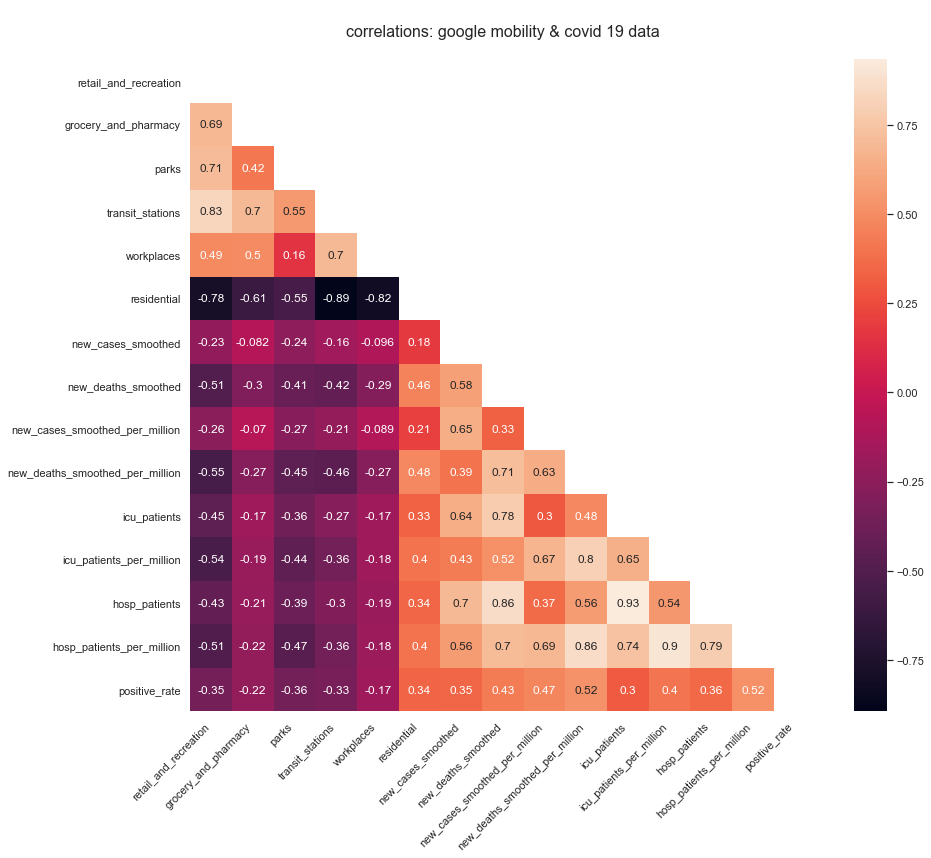

In [186]:
from pyf.eda import show_heatmap

# correlation heatmap
show_heatmap(mobility['all_targets'], 14, 12, title='correlations: google mobility & covid 19 data')


In [187]:
# Paired density and scatterplot matrix

# pgrid_1 = sns.PairGrid(g_mob_covid, diag_sharey=False)
# pgrid_1.map_upper(sns.scatterplot, s=15)
# pgrid_1.map_lower(sns.kdeplot)
# pgrid_1.map_diag(sns.kdeplot, lw=2)

### 3.2.2 facebook mobility data

### 3.2.3 google trends data

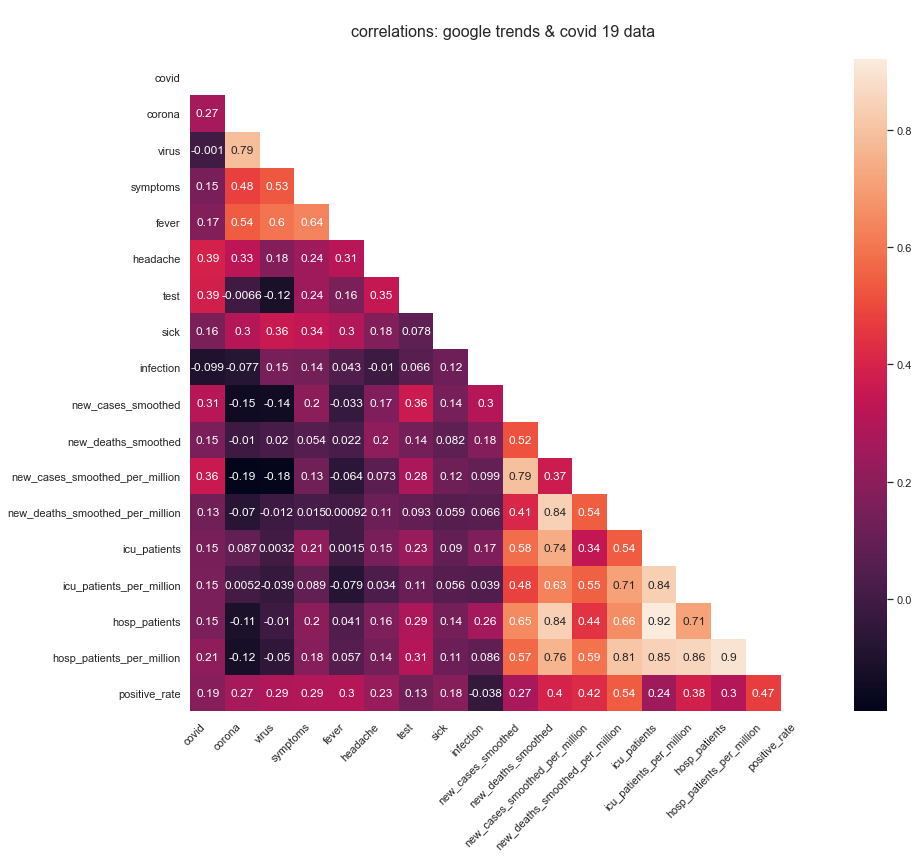

In [188]:
# correlation heatmap
show_heatmap(trends['all_targets'], 14, 12, title='correlations: google trends & covid 19 data')

### 3.2.4 twitter trends data

### 3.2.5 covid 19 data

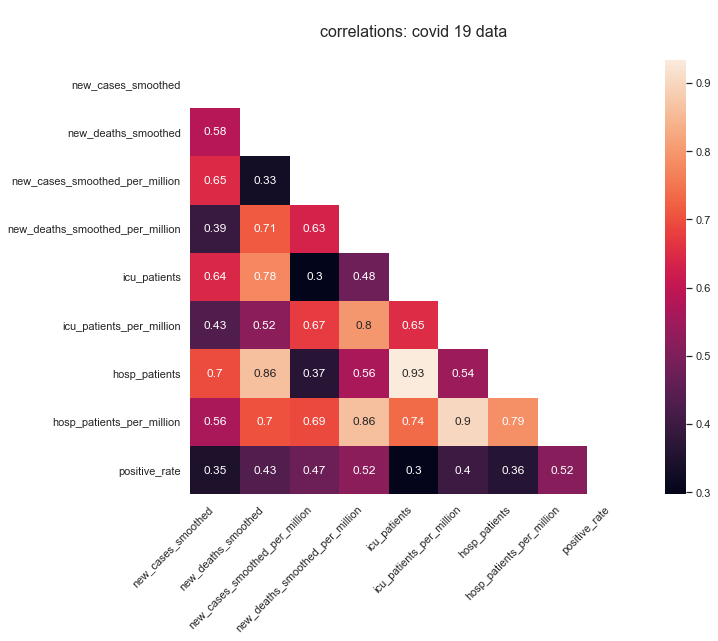

In [189]:
# correlation heatmap
show_heatmap(c19_full, 10, 8, title='correlations: covid 19 data')


### 3.3 visual exploration

### 3.3.1 google mobility data

In [190]:


def plot_timeseries(df, timeframe, w, h, title=''):
    # transform df to get a line for each col
    df = df.melt(timeframe, var_name='columns', value_name='vals')
    # plot
    custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
    sns.set(rc={'figure.figsize':(w,h)})
    sns.set_theme(style="whitegrid", rc=custom_params)
    sns.lineplot(x=timeframe, y="vals", hue='columns', data=df).set_title('\n' + title + '\n', fontsize=16)
    
    #axes = plt.gca()
    #axes.yaxis.grid()
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45, ha='right')
    plt.show()


# TO DO
# daily > weelky data for plots
# removes v grid lines
# plot in different ways (by country, c19 data only features together with similar scales, ...)
    
    
# Plot the responses for different events and regions




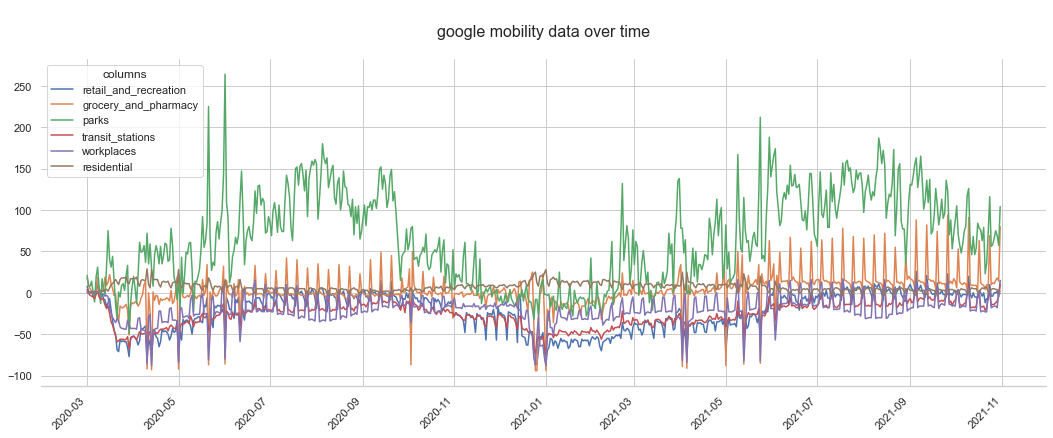

In [191]:
mobility_plotting = data_mobility[data_mobility['location'] == 'DEU']
mobility_plotting = mobility_plotting.drop(['location', 'season'], axis=1)

plot_timeseries(mobility_plotting, 'date', 18, 6, 'google mobility data over time')

### 3.3.2 facebook mobility data

### 3.3.3 google trends data

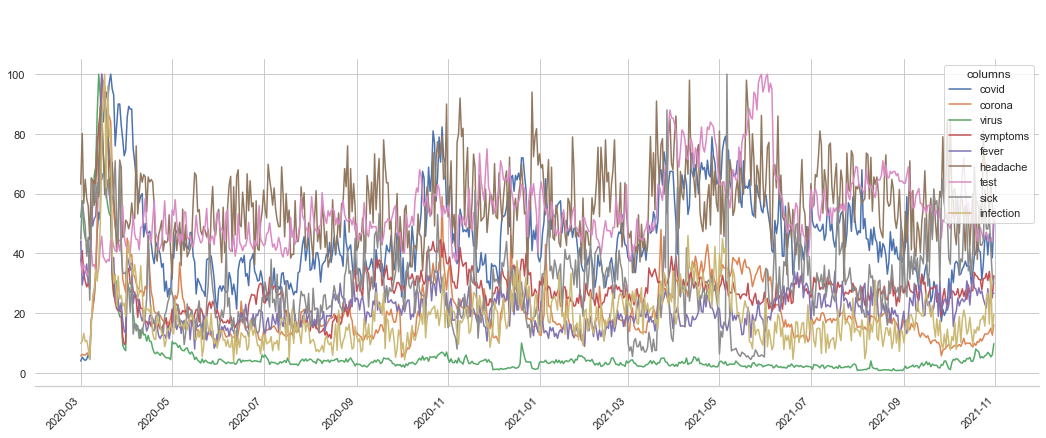

In [192]:
trends_plotting = trends_temp[trends_temp['location'] == 'DEU']
trends_plotting = trends_plotting.drop(['location'], axis=1)

plot_timeseries(trends_plotting, 'date', 18, 6)

### 3.3.4 twitter trends data

### 3.3.5 covid 19 data

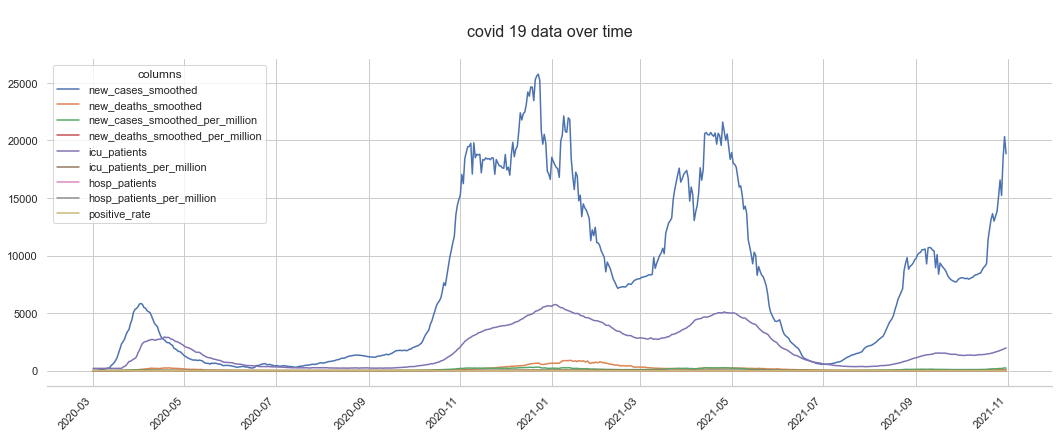

In [193]:
c19_plotting = c19_full[c19_full['location'] == 'DEU']
c19_plotting = c19_plotting.drop(['location'], axis=1)

plot_timeseries(c19_plotting, 'date', 18, 6, 'covid 19 data over time')

# 4 | data preprocessing

### 4.1 mobility data

### 4.1.1 feature selection

**feature selection by correlation**

In [194]:


# in case to features have corr above 0.8 eliminate feature with lower corr with target var




**further feature selection**

In [195]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import VarianceThreshold
import statsmodels.api as sm
from pyf.preprocessing import feature_selection_indicators

# check indicators for column variance, multi colinearity (VIF) and p values 
mobility_featind = feature_selection_indicators(mobility['new_cases_smoothed_per_million'], 'new_cases_smoothed_per_million')


In [196]:
mobility_featind

,variance,p value,VIF
const,-,0.000,8.922
retail_and_recreation,686.079855,0.000,5.104
grocery_and_pharmacy,489.274331,0.000,2.192
parks,5809.399452,0.000,2.681
transit_stations,449.104287,0.003,6.987
workplaces,350.751591,0.147,4.906
residential,57.051396,0.196,11.118


**additional selection approaches**

In [197]:
# chi2 test not neccessary because only one cat. feature
# check feat selct form classroom material and mention

### 4.1.2 target variable time lag

In [198]:
from pyf.preprocessing import timeseries_clustered_target_lags

# create different dfs for a lagging target variable between 3 and 21 days
mobility_cases = timeseries_clustered_target_lags(mobility['new_cases_smoothed_per_million'], 'date', 'location', 'new_cases_smoothed_per_million', min_lag=3, max_lag=21)


### 4.1.3 encoding categorical features

In [199]:
from pyf.transform import encoding_get_dummies

# dict to store encoded datasets
mobility_cases_encoded = {}

# encoding categorical col with get dummies
for k, v in mobility_cases.items():
    dataset_encoded = encoding_get_dummies(df=v, drop_first=False)
    mobility_cases_encoded[k] = dataset_encoded


### 4.1.4 train-test-split

In [200]:


# TODO:
# next func for model and scores
# func to filter pred by feat eg. country: recombined x train and test with original df (index has to match) > filter > scores from filtered x and y test and pred (check 7.01)
# flow: base line modele, eval > no random test test but end of timeframe, eval 
# > compare targets, lags, eval > compare models, eval> model impr.: transformation, eval, hyperparam tuning, eval 




In [201]:
from sklearn.model_selection import train_test_split
from pyf.models import train_test_split_items

# dict for all resulting dfs
mobility_cases_modeldata = {}

# create train test splits 
for k,v in mobility_cases_encoded.items():
    modeldata = v
    mobility_cases_modeldata[k] = train_test_split_items(df=modeldata, timeframe='date', test_size=0.2, random_state=84, as_timeseries=True)



In [311]:
mobility_cases_modeldata['lag_10']['X_train'].head()

,location_AUT,location_CZE,location_DEU,location_DNK,location_ESP,location_FRA,location_GBR,location_GRC,location_ITA,location_NLD,location_POL,location_PRT,location_SWE,season_fall,season_spring,season_summer,season_winter,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,8.0,6.0,1.0,2.0,0.0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,-19.0,-5.0,-30.0,-26.0,-5.0,4.0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,21.0,-7.0,-5.0,5.0,1.0,0.0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,3.0,4.0,2.0,2.0,1.0,0.0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,7.0,-7.0,30.0,10.0,2.0,1.0


### 4.2 trends data

### 4.2.1 feature selection

**feature selection by correlation**

In [203]:


# in case to features have corr above 0.8 eliminate feature with lower corr with target var




**further feature selection**

In [204]:
# check indicators for column variance, multi colinearity (VIF) and p values 
trends_featind = feature_selection_indicators(trends['new_cases_smoothed_per_million'], 'new_cases_smoothed_per_million')


In [205]:
trends_featind

,variance,p value,VIF
const,-,0.000,16.793
covid,310.823118,0.000,1.522
corona,133.062296,0.000,3.762
virus,117.833931,0.003,4.273
symptoms,126.244938,0.000,1.982
fever,152.612674,0.000,2.118
headache,341.510789,0.031,1.392
test,271.60906,0.000,1.448
sick,217.715247,0.000,1.222
infection,421.854166,0.000,1.179


**additional selection approaches**

In [206]:
# chi2 test not neccessary because only one cat. feature

### 4.2.2 target variable time lag

In [207]:
# create different dfs for a lagging target variable between 3 and 14 days
trends_cases = timeseries_clustered_target_lags(trends['new_cases_smoothed_per_million'], 'date', 'location', 'new_cases_smoothed_per_million', min_lag=3, max_lag=14)


### 4.2.3 encoding categorical features

In [208]:
# dict to store encoded datasets
trends_cases_encoded = {}

# encoding categorical col with get dummies
for k, v in trends_cases.items():
    dataset_encoded = encoding_get_dummies(df=v, drop_first=False)
    trends_cases_encoded[k] = dataset_encoded


### 4.2.4 train test split

In [209]:
# dict for all resulting dfs
trends_cases_modeldata = {}

# create train test splits 
for k,v in trends_cases_encoded.items():
    modeldata = v
    trends_cases_modeldata[k] = train_test_split_items(df=modeldata, timeframe='date', test_size=0.2, random_state=84, as_timeseries=True)


# 5 | Baseline model

### 5.1 Baseline model using mobility data

In [210]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from pyf.models import regression_model_and_evaluation, regression_model_comparison, regression_model_evaluation_metrics, regression_model_evaluation_clustered
    

In [211]:
# create list of model titles
fr_title_list = ['RF_cases_lag' + str(d) for d in range(3,22)]
fr_title_list.insert(0, 'RF_cases_nolag')

# execute models and get metrics
rf_mobility_cases, rf_mobility_cases_comp = regression_model_comparison(datasets=mobility_cases_modeldata, titles=fr_title_list, model_type=RandomForestRegressor)

In [337]:
mobility_cases_modeldata['lag_10']['X_test'].head()

,location_AUT,location_CZE,location_DEU,location_DNK,location_ESP,location_FRA,location_GBR,location_GRC,location_ITA,location_NLD,location_POL,location_PRT,location_SWE,season_fall,season_spring,season_summer,season_winter,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
6240,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-14.0,-8.0,61.0,-20.0,-41.0,5.0
6241,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,12.0,42.0,148.0,-2.0,-14.0,-3.0
6242,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0,13.0,80.0,-20.0,-23.0,2.0
6243,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-15.0,8.0,53.0,-13.0,-14.0,2.0
6244,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.0,12.0,114.0,-34.0,-22.0,6.0


### 5.2 evaluation of mobility data baseline model 

In [213]:
rf_mobility_cases_comp

,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_nolag,0.974,-0.364,-0.384,121.158,175.978,30968.178
1,RF_cases_lag3,0.973,-0.388,-0.408,125.581,177.516,31512.089
2,RF_cases_lag4,0.972,-0.355,-0.375,123.897,175.384,30759.639
3,RF_cases_lag5,0.972,-0.368,-0.388,125.838,176.421,31124.418
4,RF_cases_lag6,0.972,-0.371,-0.391,126.399,176.607,31190.187
5,RF_cases_lag7,0.973,-0.346,-0.366,125.564,174.991,30621.784
6,RF_cases_lag8,0.973,-0.337,-0.357,125.383,174.428,30425.162
7,RF_cases_lag9,0.972,-0.323,-0.343,125.225,173.505,30104.120
8,RF_cases_lag10,0.973,-0.307,-0.327,125.600,172.629,29800.640
9,RF_cases_lag11,0.973,-0.310,-0.330,125.768,172.799,29859.476


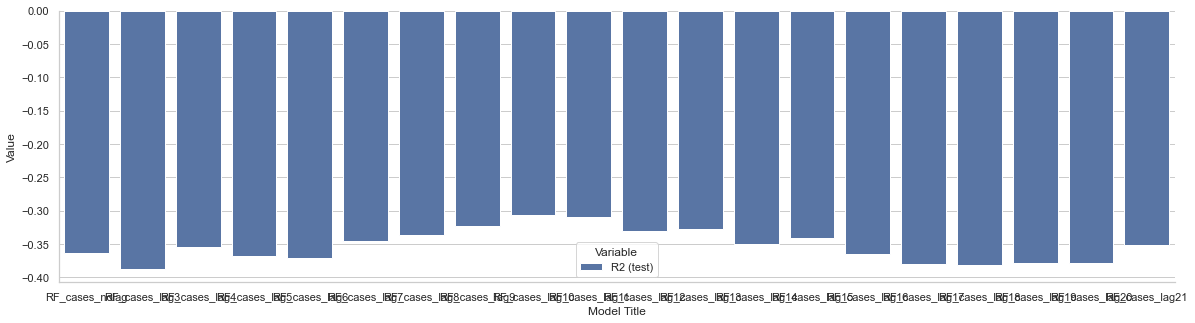

In [215]:
fig, ax1 = plt.subplots(figsize=(20, 5))
tidy = rf_mobility_cases_comp.melt(id_vars='model title').rename(columns=str.title)
tidy = tidy[tidy['Variable'] == 'R2 (test)']
sns.barplot(x='Model Title', y='Value', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)


In [216]:
# get preformance metrics for 11 days lag clustered by location
lag11_clustered = regression_model_evaluation_clustered(dataset=rf_mobility_cases['lag_11'], cluster_by='location', undummify=True)

In [217]:
lag11_clustered

,model title,location,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_lag11,GRC,0.973,-15.645,-19.633,206.901,213.592,45621.601
0,RF_cases_lag11,ITA,0.973,-6.001,-7.678,62.667,74.683,5577.594
0,RF_cases_lag11,PRT,0.973,-1.375,-1.944,129.285,139.472,19452.372
0,RF_cases_lag11,NLD,0.973,-1.451,-2.038,149.687,204.342,41755.829
0,RF_cases_lag11,ESP,0.973,-0.600,-0.983,186.475,230.135,52962.144
0,RF_cases_lag11,GBR,0.973,-16.021,-20.099,350.550,364.573,132913.163
0,RF_cases_lag11,DEU,0.973,-0.678,-1.080,54.577,69.130,4778.986
0,RF_cases_lag11,FRA,0.973,-1.902,-2.597,160.387,190.768,36392.287
0,RF_cases_lag11,AUT,0.973,-0.347,-0.670,98.341,125.601,15775.499
0,RF_cases_lag11,DNK,0.973,-3.520,-4.603,91.946,108.508,11773.882


<AxesSubplot:ylabel='new_cases_smoothed_per_million_lag11'>

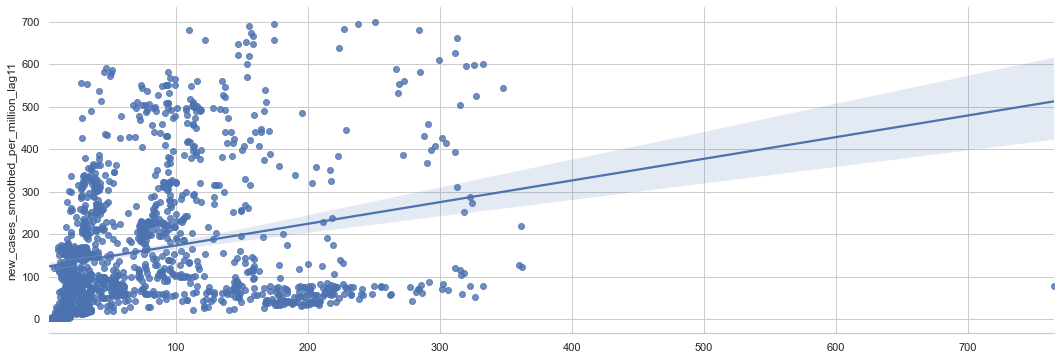

In [338]:
sns.regplot(rf_mobility_cases['lag_11']['predictions'], rf_mobility_cases['lag_11']['y_test'])

### 5.3 Baseline model using google trends data

In [218]:
# create list of model titles
fr_trends_title_list = ['RF_cases_lag' + str(d) for d in range(3,15)]
fr_trends_title_list.insert(0, 'RF_cases_nolag')

rf_trends_cases, rf_trends_cases_metrics = regression_model_comparison(datasets=trends_cases_modeldata, titles=fr_title_list, model_type=RandomForestRegressor)


### 5.4 evaluation of mobility data baseline model 

In [219]:
rf_trends_cases_metrics

,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_nolag,0.948,0.014,-0.003,131.850,171.314,29348.613
1,RF_cases_lag3,0.951,0.011,-0.007,131.954,171.566,29434.746
2,RF_cases_lag4,0.952,0.041,0.024,129.692,168.996,28559.706
3,RF_cases_lag5,0.953,0.045,0.028,128.934,168.839,28506.636
4,RF_cases_lag6,0.954,0.040,0.023,127.740,169.302,28663.225
5,RF_cases_lag7,0.954,0.049,0.032,128.930,168.547,28408.084
6,RF_cases_lag8,0.951,0.026,0.009,130.014,170.507,29072.572
7,RF_cases_lag9,0.954,0.049,0.032,129.180,168.552,28409.735
8,RF_cases_lag10,0.952,0.038,0.021,127.893,169.766,28820.530
9,RF_cases_lag11,0.950,0.030,0.012,130.304,170.426,29044.971


In [220]:
# sns.regplot(preds, y_test)

# 6 | Mobility data model

### 6.1. model improvements

### 6.1.1. alternative target variables

### 6.1.2. feature transformations

**boxcox transformation**

In [340]:
# copy dataset for boxcox
mob_boxcox = mobility_cases_modeldata['lag_10'].copy()
mob_boxcox_columns = ['retail_and_recreation','grocery_and_pharmacy','parks','transit_stations','workplaces','residential']


In [341]:
# function to display distribution plots and boxplots of columns in a df

def plots_continuous_var(df, columns=[], skip=[]):
    if columns == []:
        columns = df.columns
    for column in columns:
        if column not in skip:
            print('\n')
            custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
            sns.set_theme(style="whitegrid", rc=custom_params)
            fig, axes = plt.subplots(1, 2, figsize=(18, 5))
            sns.distplot(df[column], ax=axes[0])
            sns.boxplot(df[column], ax=axes[1])
            plt.show()

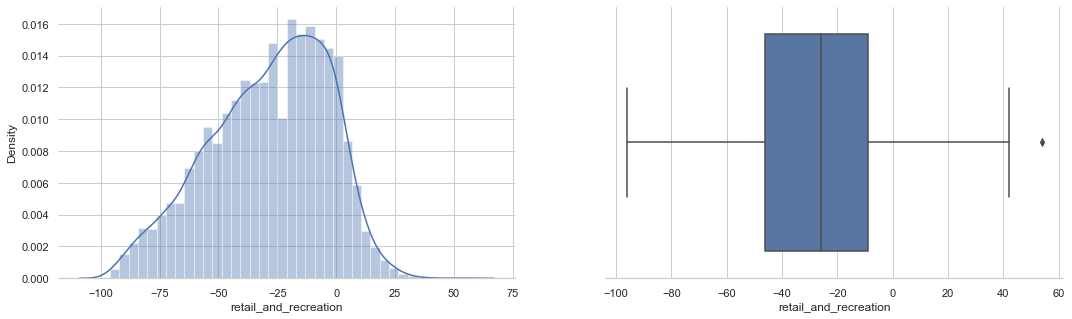

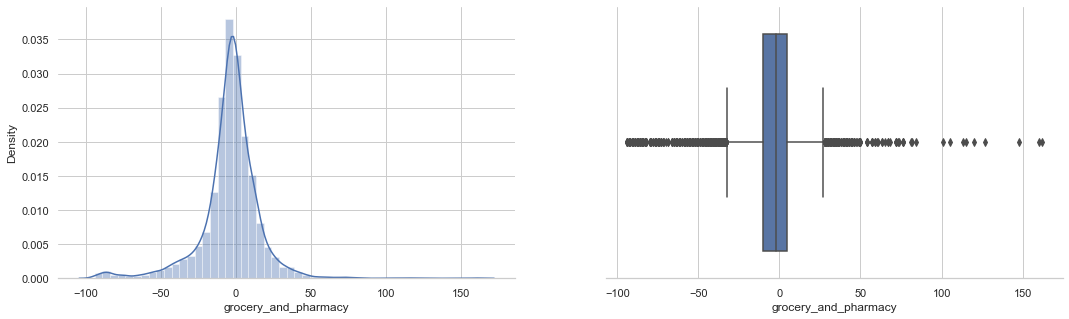

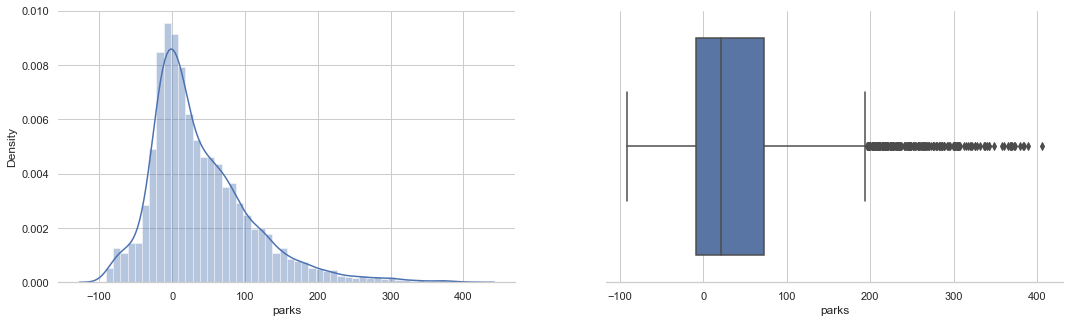

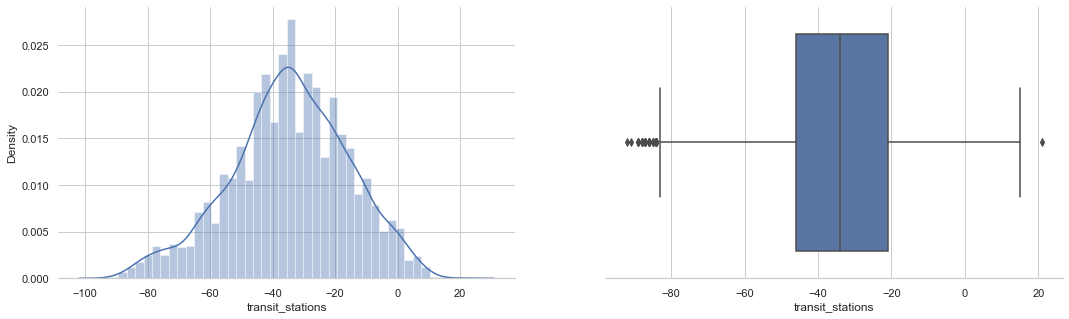

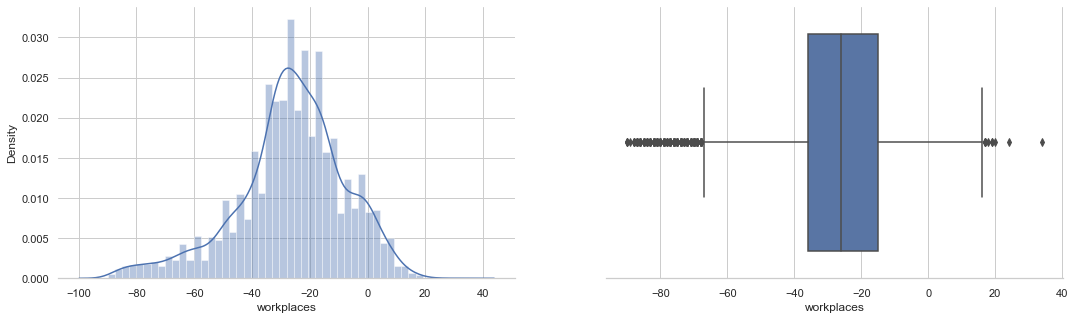

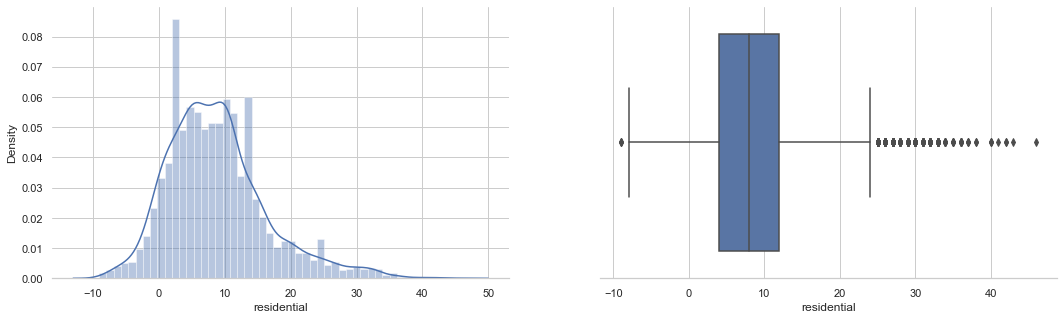

In [343]:
plots_continuous_var(mob_boxcox['X_train'], columns=mob_boxcox_columns)

In [340]:
def boxcox_transform(df, columns=[], skip=[], fit=''):
    if columns == []:
        columns = df.select_dtypes(np.number).columns
    _ci = {column: None for column in columns}
    
    for column in columns:
        if column not in skip:
            df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
            df[column] = df[column].fillna(df[column].median())
            if fit == '':
                transformed_data, ci = stats.boxcox(df[column])
                df[column] = transformed_data
                _ci[column] = [ci] 
            else:
                transformed_data = stats.boxcox(df[column], fit[column])
                _ci = fit
    return df, _ci

In [344]:
mob_boxcox_Xtrain, _bxcx = boxcox_transform(mob_boxcox['X_train'], columns=mob_boxcox_columns)


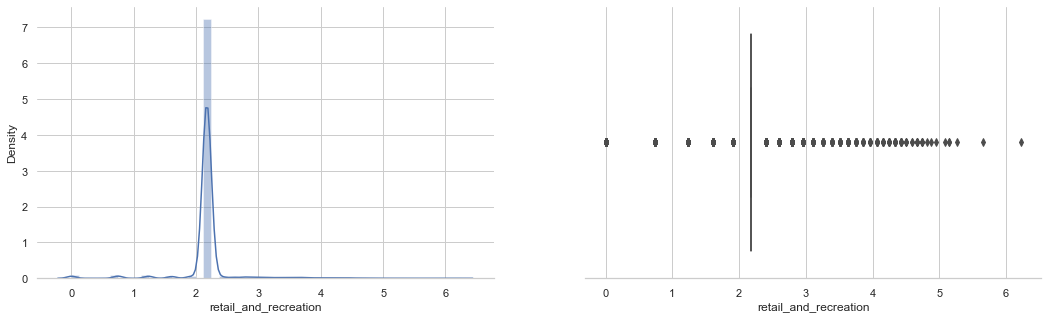

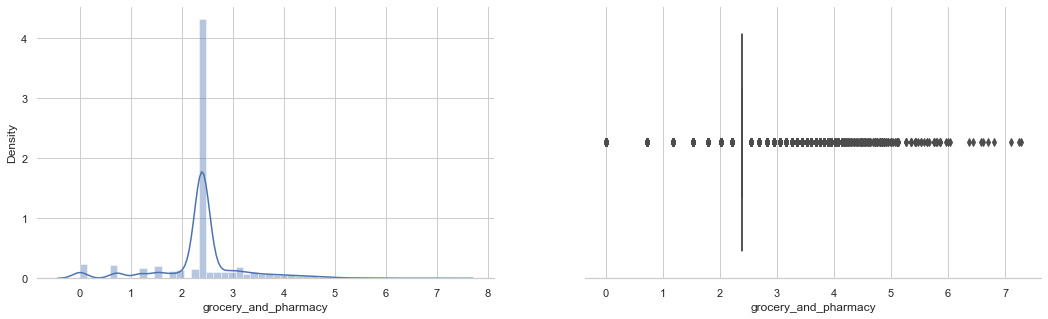

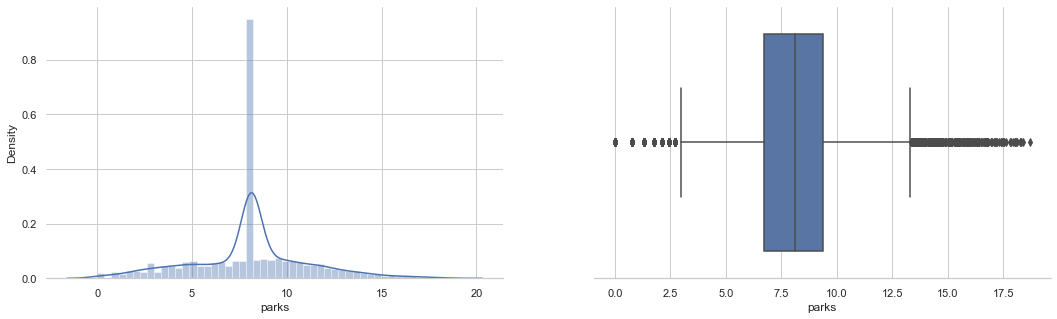

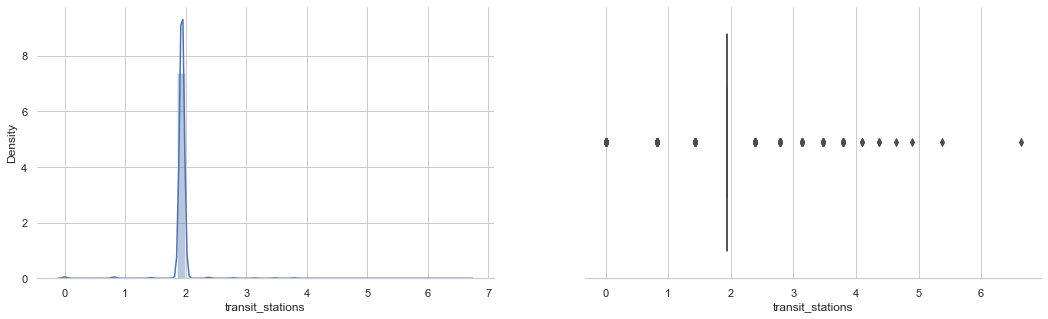

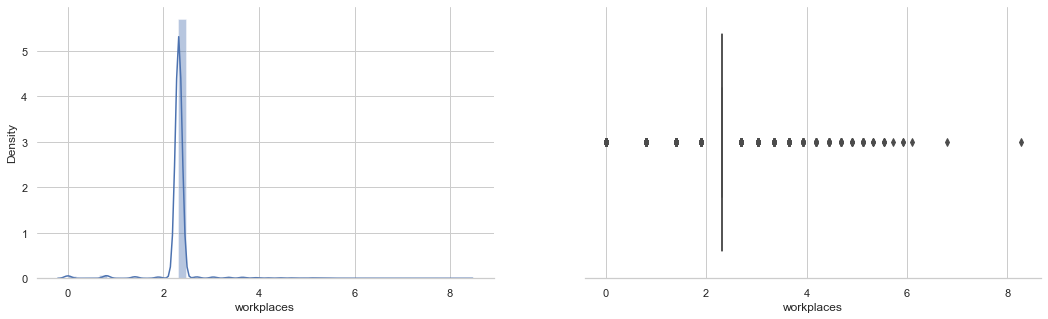

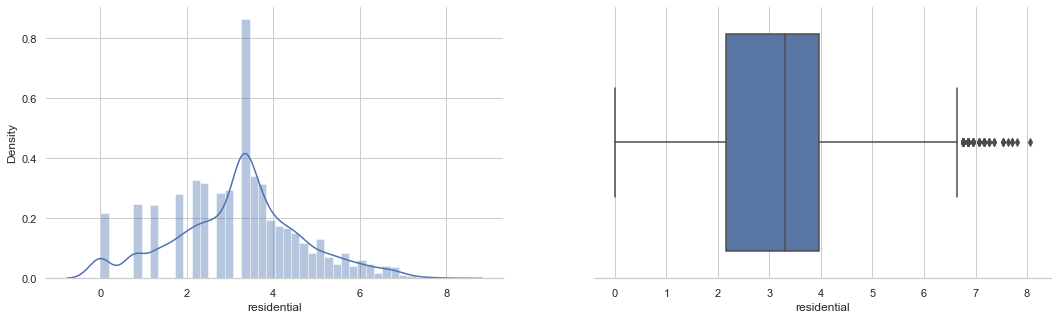

In [345]:
plots_continuous_var(mob_boxcox_Xtrain, columns=mob_boxcox_columns)


**feature scaling**

In [332]:
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from pyf.transform import scaling_model_dataset, invert_scaling_model_dataset

# copy dataset for scaling
mob_test = mobility_cases_modeldata['lag_10'].copy()
mob_scale_columns = ['retail_and_recreation','grocery_and_pharmacy','parks','transit_stations','workplaces','residential']

# scaling features
mob_test, stdsc_1 = scaling_model_dataset(dataset=mob_test, in_columns=mob_scale_columns, transformer_type=StandardScaler, target=False)

# scaling target var
mob_test, minmax_1 = scaling_model_dataset(dataset=mob_test, transformer_type=MinMaxScaler, target=True)

# model with scaled data and get evaluation metrics
rf_scaled, rf_scaled_metrics = regression_model_and_evaluation(dataset=mob_test, title='RF_cases_lag10 (scaled)', model_type=RandomForestRegressor)


In [296]:
# performance pre scaling
rf_mobility_cases_comp[rf_mobility_cases_comp['model title'] == 'RF_cases_lag10']


,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
8,RF_cases_lag10,0.973,-0.307,-0.327,125.6,172.629,29800.64


In [333]:
# performance after scaling
rf_scaled_metrics


,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_lag10 (scaled),0.972,-0.313,-0.333,0.09,0.124,0.015


### 6.1.2. handling outliers

In [ ]:
# Replace outliers with the median or alternatively windsorize.
# inputs: the data frame, threshold value which serves as a multiplication for the threshold above which to windsorizer

def replace_outliers(df, threshold=1.5, columns=[], skip=[], limit=[]):
    if columns == []:
        columns = df.select_dtypes(np.number).columns
    for column in columns:
        if column not in skip:
            upper = np.percentile(df[column],75)
            lower = np.percentile(df[column],25)
            iqr = upper - lower
            upper_limit = upper + (threshold * iqr)
            lower_limit = lower - (threshold * iqr)
            
            if column in limit:
                df.loc[df[column] > upper_limit, column] = upper_limit
                df.loc[df[column] < lower_limit, column] = lower_limit
            else:
                df.loc[df[column] > upper_limit, column] = df[column].median()
                df.loc[df[column] < lower_limit, column] = df[column].median()
    return df


### 6.1.2. hyperparameter tuning

### 6.2. model algorithms 

### 6.2.1. Random Forrest 

### 6.2.2 XGBoost

### 6.2.3. SARIMAX model

In [ ]:
# copy dataset with no lag
mob_nolag = mobility_cases_modeldata['nolag'].copy()

### 6.3. comparing models

### 6.4 detailed evaluation

In [335]:
mob_unscale = mob_test.copy()

# unscaling features
mob_unscale = invert_scaling_model_dataset(dataset=mob_unscale, in_columns=mob_scale_columns, load_transformer=stdsc_1, target=False)

# unscaling target var
mob_unscale = invert_scaling_model_dataset(dataset=mob_unscale, load_transformer=minmax_1, target=True)

mob_unscale['X_test'].head()

,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,location_AUT,location_CZE,location_DEU,location_DNK,location_ESP,location_FRA,location_GBR,location_GRC,location_ITA,location_NLD,location_POL,location_PRT,location_SWE,season_fall,season_spring,season_summer,season_winter
6240,-14.0,-8.0,61.0,-20.0,-41.0,5.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
6241,12.0,42.0,148.0,-2.0,-14.0,-3.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
6242,0.0,13.0,80.0,-20.0,-23.0,2.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
6243,-15.0,8.0,53.0,-13.0,-14.0,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6244,0.0,12.0,114.0,-34.0,-22.0,6.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


# 7 | Google trends data models

### 7.1. model improvements

### 7.1.1. feature transformations

### 7.1.2. handling outliers

### 7.1.2. hyperparameter tuning

### 7.2. model algorithms 

### 7.2.1. Random Forrest 

### 7.2.2 XGBoost

### 7.2.3. ARIMA model

### 7.3. comparing models

### 7.4 detailed evaluation